In [3]:

'''
Cvacc[i] = cost of vaccination for node i
Cinf[i]: cost of infection for node i
x[i]: current strategy of node i
    x[i] = 1 ==> i is vaccinated
S(x): set of vaccinated nodes
comp(x): components formed by residual nodes
cost[i]: cost of node i

#Evaluating reduction in cost for node i
#return old cost - new cost
def reduction_in_cost(x, comp, cost, Cvacc, Cinf, i)
    if x[i] == 0, then return  cost[i] - Cvacc[i]
    if x[i] == 1
        A = {comp(j, x): j is a nbr of i }
        N = \sum_{X in A} |X|
        return  Cvacc[i] - N^2 Cinf[i]/n

#best response
def best_respose(Cvacc, Cinf)
    xinit: random strategy
    initialize comp, cost
    for t = 1.. T:
        for i in V:
            if reduction_in_cost(x, i) > 0:
                flip x[i]
                update comp

#possible efficiencies
    #uniform Cvacc, Cinf setting
        if there is a large comp X: check benefit of vaccination
        if all comp are small: check benefit of not vaccinating
'''
import numpy as np
import networkx as nx
#import EoN
import matplotlib.pyplot as plt
import csv, random, pdb, sys
from IPython.core.debugger import set_trace
import copy



In [6]:

#each line: id1, id2
def read_graph(fname):
    G = nx.Graph()
    fp_reader = csv.reader(open(fname), delimiter = ' ')
    headers = next(fp_reader) 
    count = 0
    for line in fp_reader:
        if line[1] != line[2]: 
            G.add_edge(line[1], line[2])
        count += 1
        if count >= 1000:
            break
    return G

#create components
#x: strategy vector where x[i] = 1 means i is vaccinated
def init_comp(G, x):

    # comp_id: {node u: component_id i}; mapping of each node to it's current component id
    # comp_len: {component_id i: length(int)}; mapping of component id to its length
    # comp_d: {component_id i: list of node in ith component}
    # max_comp_id: integer; each time we create a new component id so it will be helpful.
    comp_id = {}; comp_len = {}; comp_d = {}; max_comp_id = 0
    
    H = nx.Graph()
    for u in G.nodes(): 
        H.add_node(u)
    for e in G.edges():
        u = e[0]; v = e[1]
        if x[u] == 0 and x[v] == 0: #both nodes unvacccinated
            H.add_edge(u, v)
    comp = nx.connected_components(H)
    
    for c in list(comp):
        max_comp_id += 1
        for u in c: 
            comp_id[u] = max_comp_id
        comp_len[max_comp_id] = len(list(c))
        comp_d[max_comp_id] = list(c)

    return H, comp_d, comp_id, comp_len, max_comp_id

def comp_cost(x, comp_id, comp_len, Cvacc, Cinf):
    cost = {}
    for i in x:
        if x[i] == 1: 
            cost[i] = Cvacc[i]
        else: 
            cost[i] = comp_len[comp_id[i]]*Cinf[i]/(len(x)+0.0)
    return cost


#return reduction in cost if node u flips its strategy
def reduction_in_cost(G, x, comp_id, comp_len, cost, Cvacc, Cinf, u):
    if x[u] == 0: 
        return  cost[u] - Cvacc[u]
    if x[u] == 1:
        nbr_comp = {}; z = 1
        for v in G.neighbors(u): 
            if x[v] == 0: 
                nbr_comp[comp_id[v]] = 1
        for j in nbr_comp: 
            z += comp_len[j]
        return cost[u] - z*Cinf[u]/(len(x)+0.0)


def check_NE(G, x, comp, comp_id, comp_len, cost, Cvacc, Cinf):
    num_violated = 0
    for u in G.nodes():
        if reduction_in_cost(G, x, comp_id, comp_len, cost, Cvacc, Cinf, u) > 0: 
            num_violated += 1
    return num_violated

#remove node u and split its comp
#use ids starting from comp_max_id + 1
def remove_node(G, x, comp_d, comp_id, comp_len, comp_max_id, u):
    
    C = set(comp_d[comp_id[u]])
    C.remove(u); 
    del comp_d[comp_id[u]]; 
    del comp_len[comp_id[u]]
    comp_max_id += 1; comp_id[u] = comp_max_id; comp_d[comp_max_id] = [u]; comp_len[comp_max_id] = 1
    H = nx.Graph()
    for v in C: 
        H.add_node(v)
    for v1 in C: 
        for v2 in G.neighbors(v1):
            if v2 in C: H.add_edge(v1, v2)
    comp1 = nx.connected_components(H)
    comp = list(comp1).copy()
    
    for c in list(comp):
        comp_max_id += 1
        comp_d[comp_max_id] = list(c); comp_len[comp_max_id] = len(c)
        for v in list(c): comp_id[v] = comp_max_id
    return comp_d, comp_id, comp_len, comp_max_id

#add node u and create comp
def add_node(G, x, comp_d, comp_id, comp_len, comp_max_id, u):
    Tu = comp_d[comp_id[u]].copy()
    del comp_d[comp_id[u]]
    del comp_len[comp_id[u]]
    
    comp_max_id += 1
    S = set([u])

    for v in G.neighbors(u):
        if x[v] == 0: #v is not vaccinated
            if comp_id[v] != comp_id[u] and comp_id[v] in comp_d:
                T = set(comp_d[comp_id[v]].copy())
            elif comp_id[v] == comp_id[u]:
                T = set(Tu)
            S = S | T
            if comp_id[v] in comp_d: 
                del comp_d[comp_id[v]]
                del comp_len[comp_id[v]]
            for vprime in T: comp_id[vprime] = comp_max_id

    #merge the components containing S into one
    comp_id[u] = comp_max_id
    comp_d[comp_max_id] = list(S)
    comp_len[comp_max_id] = len(S)

    return comp_d, comp_id, comp_len, comp_max_id
            
#flip strategy of node u
def update_strategy(x, G, H, comp_d, comp_id, comp_len, cost, Cvacc, Cinf, comp_max_id, u):

    if x[u] == 0:
        x[u] = 1
        comp_d, comp_id, comp_len, comp_max_id = remove_node(G, x, comp_d, 
                                                             comp_id, comp_len, comp_max_id, u)
        cost[u] = Cvacc[u]
        return x, comp_d, comp_id, comp_len, cost, comp_max_id

    else: #x[u] = 1
        x[u] = 0
        comp_d, comp_id, comp_len, comp_max_id = add_node(G, x,
                                                          comp_d, comp_id, comp_len, comp_max_id, u)
        cost[u] = comp_len[comp_id[u]]*Cinf[u]/(len(x)+0.0)
        return x, comp_d, comp_id, comp_len, cost, comp_max_id
        
def print_analysis(comp_id, comp_len): 
    component_ids = np.unique(list(comp_id.values()))  
    component_lengths = [comp_len[i] for i in component_ids] 
    avg_comp_size = round(np.mean(component_lengths),2)
    max_comp_size = np.max(component_lengths)
    #print("Average component size: ", avg_comp_size)
    #print("Max component size: ", max_comp_size) 
    return avg_comp_size, max_comp_size  

#start at strategy x and run for T steps
def best_response(G, Cvacc, Cinf, x, T, epsilon=0.05):
    if len(x) == 0:
        for u in G.nodes(): x[u] = np.random.randint(0, 2)
    
    H, comp_d, comp_id, comp_len, comp_max_id = init_comp(G, x)
    #print('x', x)
    cost = comp_cost(x, comp_id, comp_len, Cvacc, Cinf)
    V = G.nodes(); itrn = 0
    for t in range(T):
        #u = random.choice(list(V)); 
        num_updated = 0
        flag = {}

        count = 0 
        while count < len(V):
            u = random.choice(list(V))
            if u in flag:
                continue

            flag[u]= 1
            count += 1
#             itrn += 1
#             if (itrn % 10 == 0): print(itrn)
            if reduction_in_cost(G, x, comp_id, comp_len, cost, Cvacc, Cinf, u) > 0:
                x, comp_d, comp_id, comp_len, cost, comp_max_id = update_strategy(x, 
                                    G, H, comp_d, comp_id, comp_len, cost, Cvacc, Cinf, comp_max_id, u)
                num_updated += 1

        if num_updated == 0:
            print("times: ", t)
            avg_comp_size, max_comp_size = print_analysis(comp_id, comp_len)
            return x, check_NE(G, x, comp_d, comp_id, comp_len, cost, Cvacc, Cinf), avg_comp_size, max_comp_size, comp_id, comp_len, comp_d
    
    avg_comp_size, max_comp_size = print_analysis(comp_id, comp_len)
    return x, check_NE(G, x, comp_d, comp_id, comp_len, cost, Cvacc, Cinf), avg_comp_size, max_comp_size, comp_id, comp_len, comp_d


# #start at strategy x and run for T steps
# def best_response_v2(G, Cvacc, Cinf, x, T, epsilon=0.05):
#     if len(x) == 0:
#         for u in G.nodes(): x[u] = np.random.randint(0, 2)
    
#     H, comp_d, comp_id, comp_len, comp_max_id = init_comp(G, x)
#     #print('x', x)
#     cost = comp_cost(x, comp_id, comp_len, Cvacc, Cinf)
#     V = G.nodes(); itrn = 0
#     for t in range(T):
#         #u = random.choice(list(V)); 
#         num_updated = 0
#         for u in G.nodes():
# #             itrn += 1
# #             if (itrn % 10 == 0): print(itrn)
#             num_updated += update_if_reduce(x, G, H, comp_d, comp_id, comp_len, 
#                                             cost, Cvacc, Cinf, comp_max_id, u)
#         if num_updated <= epsilon*len(x): return x, num_updated
#     return x, num_updated

def save_file(filename, data):
    with open(filename, 'w') as f:
        for row in data:
            for item in row:
                f.write("%s\t" % item)
            f.write("\n")


def save_degree_hist(comp_id, comp_len, comp_d, G, alpha):     
    component_ids = np.unique(list(comp_id.values()))  
    component_lengths = [comp_len[i] for i in component_ids] 
    index_max = np.argmax(component_lengths)
    max_comp = component_ids[index_max]
    max_comp_nodes = comp_d[max_comp]
    max_nodes_degrees = [G.degree(node) for node in max_comp_nodes]
    plt.hist(max_nodes_degrees, density=False, bins=20)  # `density=False` would make counts
    plt.ylabel('Num of nodes')
    plt.xlabel('Degree');
    plt.title("Histogram of degrees for Max Component Nodes; alpha: " + str(alpha) + "; len: " + str(len(max_comp_nodes)))
    plt.savefig("../out/fig/max_comp_nodes_alpha_" + str(alpha) + ".png")
    plt.show()

def save_graph_data(comp_id, comp_len, comp_d, G):     
    graph_data = {}
    graph_data['comp_id'] = comp_id
    graph_data['comp_len'] = comp_len
    graph_data['comp_d'] = comp_d
    graph_data['nodes'] = list(G.nodes())
    graph_data['edges'] = list(G.edges())
    graph_data['degree'] = dict(G.degree)
    return graph_data



def remove_topk_nodes(G, k):
    degree_tup = list(dict(G.degree).items())
    degree_tup = sorted(degree_tup, key=lambda x: -1*x[1])
    top_k_nodes = [x for x,d in degree_tup[:k]]
    G_res = copy.deepcopy(G)
    for node in top_k_nodes:
        G_res.remove_node(node)
    
    return G_res

def inital_comp_size(G):
    comp_id = {}; comp_len = {}; comp_d = {}; max_comp_id = 0
    H = nx.Graph()
    for u in G.nodes(): 
        H.add_node(u)
        
    for e in G.edges():
        u = e[0]; v = e[1]
        H.add_edge(u, v)
    comp = nx.connected_components(H)

    for c in list(comp):
        for u in c: 
            comp_id[u] = max_comp_id
        comp_len[max_comp_id] = len(list(c))
        comp_d[max_comp_id] = list(c)
        max_comp_id += 1
        
    return H, comp_d, comp_id, comp_len, max_comp_id


In [17]:
if __name__ == '__main__':
### run for a fixed network and fixed alpha
##########################################
    num_times = 10 #####
    T = 100
    epsilon = 0.001
    alphavals = 1.0/ np.arange(0.1, 1.0, 0.05)
    #alphavals = sys.argv[1]



    avg_file_name = './vacc_albemarle_household_1_7_dec7_avg.txt'
    raw_file_name = './vacc_albemarle_household_1_7_dec7_raw.txt' 
    
    raw_data = []
    np.random.seed(0)

    #### read from a fixed graph
    G = read_graph('household_undirected_albe_1.90.txt')
    # G = nx.barabasi_albert_graph(n, m)
    n = len(G.nodes())
    print("Original G num_edges:", len(G.edges()), " num_nodes:", len(G.nodes()))
    
    # Remove k nodes with highest degree. Create a dictionary of {k: max_component_size} to check 
    # which k should be chosen to initialise the graph
    k_max_comp_dict = {}

    #k percent 
    for k in range(99):
        k_node = int(k/100*len(G.nodes()))
        G_res = remove_topk_nodes(G, k_node ) # removes k% node here
        H, comp_d, comp_id, comp_len, comp_max_id = inital_comp_size(G_res) # find the comp details of the residual graph
        avg_comp_size, max_comp_size = print_analysis(comp_id, comp_len) #nothing very important
        k_max_comp_dict[k] = max_comp_size            
    
    print("Done k_max_comp_dict")

    times = 1
    total_graph_data = {}


    n_num_vacc_list = []
    n_exp_inf_list = []

    n_max_comp_list = []

    for ind, alpha in enumerate(alphavals):
        num_vacc_list = []
        exp_inf_list = []

        max_comp_list = []
        
        
        for i in range(num_times):
            # Choose k for a given alpha such that max_comp_size < n/alpha
            for k, max_comp_size in k_max_comp_dict.items():
                if max_comp_size < n/alpha:
                    k_node = int(k/100*len(G.nodes()))
                    G_res = remove_topk_nodes(G, k_node )
                    break
            
            print("alpha: ", alpha, "Top k: ", k, "max_comp_size :", max_comp_size, "Num of nodes: ", len(G_res.nodes), "Num of edges: ", len(G_res.edges))
            # Initialize graph by removing top k nodes


            x = {}; Cvacc = {}; Cinf = {}; #alpha = 10
            for u in G.nodes():
                x[u] = 1 #np.random.randint(0, 2)
                Cvacc[u] = 1; 
                Cinf[u] = Cvacc[u]*float(alpha)
                
            for u in G_res.nodes():
                x[u] = 0 #np.random.randint(0, 2)

            ## I'm guessing 1 means vaccinated and 0 means antivaxx
                
            #T = 500
            pre_vacc_nodes = len([i for i in x if x[i] == 1])
            x, nviol, avg_comp_size, max_comp_size, comp_id, comp_len, comp_d = best_response(G, Cvacc, Cinf, x, T, epsilon)
            num_vacc_nodes = len([i for i in x if x[i] == 1])
            temp = [alpha, times, avg_comp_size, max_comp_size, num_vacc_nodes, pre_vacc_nodes]
            
            
            if(nviol == 0):
                raw_data.append(temp)

                num_vacc_list.append(num_vacc_nodes)

                max_comp_list.append(max_comp_size)


                # print(comp_d)
                exp_infection = 0
                for i in comp_d:
                    exp_infection += len(comp_d[i])*len(comp_d[i])
                exp_inf_list.append(exp_infection/n)

                print("alpha: ", alpha, "Percent voilated: ", nviol/len(x), "Num of vaccinated nodes: ", num_vacc_nodes, "pre_vacc_nodes: ", pre_vacc_nodes)
                print("avg_comp_size: ", avg_comp_size, "max_comp_size: ",  max_comp_size, "\n")
                graph_data = save_graph_data(comp_id, comp_len, comp_d, G)
                #save_degree_hist(comp_id, comp_len, comp_d, G, alpha)
                total_graph_data[alpha] = graph_data

                save_file(raw_file_name, raw_data)
            #np.save('../out/total_graph_data.npy', total_graph_data) # save
            #sys.stdout.flush()
        
        n_num_vacc_list.append(num_vacc_list)
        n_exp_inf_list.append(exp_inf_list)
        n_max_comp_list.append(max_comp_list)

Original G num_edges: 1000  num_nodes: 1001
Done k_max_comp_dict
alpha:  10.0 Top k:  1 max_comp_size : 80 Num of nodes:  991 Num of edges:  532
times:  1
alpha:  10.0 Percent voilated:  0.0 Num of vaccinated nodes:  5 pre_vacc_nodes:  10
avg_comp_size:  3.82 max_comp_size:  96 

alpha:  10.0 Top k:  1 max_comp_size : 80 Num of nodes:  991 Num of edges:  532
times:  1
alpha:  10.0 Percent voilated:  0.0 Num of vaccinated nodes:  5 pre_vacc_nodes:  10
avg_comp_size:  3.82 max_comp_size:  96 

alpha:  10.0 Top k:  1 max_comp_size : 80 Num of nodes:  991 Num of edges:  532
times:  1
alpha:  10.0 Percent voilated:  0.0 Num of vaccinated nodes:  5 pre_vacc_nodes:  10
avg_comp_size:  3.82 max_comp_size:  96 

alpha:  10.0 Top k:  1 max_comp_size : 80 Num of nodes:  991 Num of edges:  532
times:  1
alpha:  10.0 Percent voilated:  0.0 Num of vaccinated nodes:  5 pre_vacc_nodes:  10
avg_comp_size:  3.59 max_comp_size:  96 

alpha:  10.0 Top k:  1 max_comp_size : 80 Num of nodes:  991 Num of edg

In [19]:
n_num_vacc_list = np.array(n_num_vacc_list)
n_exp_inf_list = np.array(n_exp_inf_list)
n_max_comp_list = np.array(n_max_comp_list)


vacc_mean = n_num_vacc_list.mean(axis = 1)
vacc_std = n_num_vacc_list.std(axis = 1)

exp_inf_mean = n_exp_inf_list.mean(axis = 1)
exp_inf_std = n_exp_inf_list.std(axis = 1)

max_comp_mean = n_max_comp_list.mean(axis = 1)
max_comp_std = n_max_comp_list.std(axis = 1)


print(exp_inf_mean)

[ 48.51048951  65.03196803  98.41598402 104.77102897 131.08151848
 164.07092907 164.07092907 164.07092907 164.07092907 164.07092907
 164.07092907 164.07092907 164.07092907 164.07092907 164.07092907
 164.07092907 164.07092907 164.07092907]


In [23]:
# c_by_alpha = [1/a for a in alphavals]

# plt.errorbar(c_by_alpha, vacc_mean, yerr=vacc_std, fmt='o')
# plt.plot(c_by_alpha, vacc_mean)
# plt.xlabel(r'$C_{vacc}/C_{inf}$')
# plt.ylabel("#vacc")
# plt.savefig('4_1.pdf')

In [ ]:

# plt.errorbar(c_by_alpha, exp_inf_mean, yerr=exp_inf_std, fmt='o')
# plt.plot(c_by_alpha, exp_inf_mean)
# plt.xlabel(r'$C_{vacc}/C_{inf$')
# plt.ylabel("E[#infection]")
# plt.show()


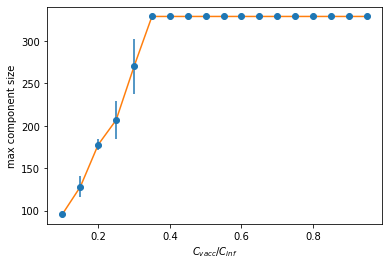

In [27]:

# plt.errorbar(c_by_alpha, max_comp_mean, yerr=max_comp_std, fmt='o')
# plt.plot(c_by_alpha, max_comp_mean)
# plt.xlabel(r'$C_{vacc}/C_{inf}$')
# plt.ylabel("max component size")

# plt.savefig('5_3.pdf')


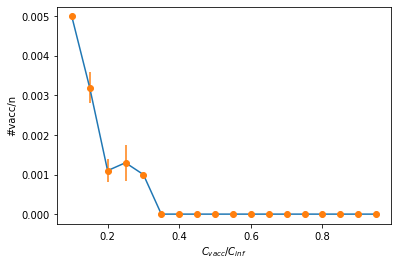

In [29]:
## normalized


plt.plot(c_by_alpha, vacc_mean/n)
plt.errorbar(c_by_alpha, vacc_mean/n, yerr=vacc_std/n, fmt='o')
plt.xlabel(r'$C_{vacc}/C_{inf}$')
plt.ylabel("#vacc/n")

plt.savefig('5_1.pdf')



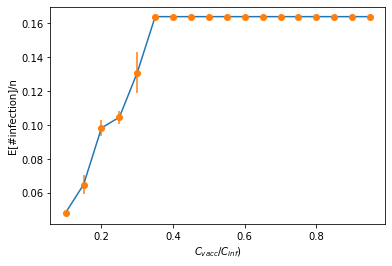

In [30]:

plt.plot(c_by_alpha, exp_inf_mean/n)
plt.errorbar(c_by_alpha, exp_inf_mean/n, yerr=exp_inf_std/n, fmt='o')
plt.xlabel(r'$C_{vacc}/C_{inf}$)')
plt.ylabel("E[#infection]/n")
plt.savefig('5_2.pdf')


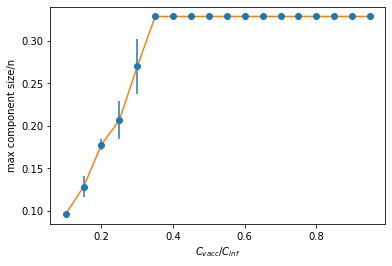

In [31]:

plt.errorbar(c_by_alpha, max_comp_mean/n, yerr=max_comp_std/n, fmt='o')
plt.plot(c_by_alpha, max_comp_mean/n)
plt.xlabel(r'$C_{vacc}/C_{inf}$')
plt.ylabel("max component size/n")

plt.savefig('5_3.pdf')


In [32]:
def compare_degree(s1):
    a = [i[1] for i in s1.degree()]
    a2 = collections.Counter(a)
    a2v = list(a2.values())
    print(a2v)
    
    
    plt.xlim(0,210)
    plt.bar(a2.keys(), np.log(a2v), width = 1)
    plt.xlabel("d"); plt.ylabel("log(Frequency)")
    plt.title("Antivaccine degree distribution")
    plt.savefig("deg_mentions_before.pdf"); plt.show()


def compare_cc(s1):
    a = [round(i,2) for i in nx.clustering(s1).values()]   #Round to 0.01,0.02,etc.
    a2 = collections.Counter(a)
    a2v = list(a2.values())
    plt.bar(a2.keys(), np.log(a2v),width=0.01)
    plt.xlabel("Clustering Coefficient"); plt.ylabel("log(Frequency)")
    plt.title("Antivaccine clustering coefficient")
    plt.savefig("cc_mentions_before.pdf"); plt.show()


In [36]:
# import collections
# from util import *
# from strategy_vector_manipulator import *

# v10 = set(get_provax(x))
# heh1 = G.subgraph(v10)
# compare_degree(heh1)
# compare_cc(heh1)